In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
import pickle
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import pairwise_distances
import pandas as pd
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import pairwise_distances

In [2]:
def anomaly_detection(mat):
    scores = []
    clf = IsolationForest(random_state = 0, n_estimators = 100)
    clf.fit_predict(mat)
    score = -clf.score_samples(mat)
    scores.append(score)

    clf = IsolationForest(random_state = 0, n_estimators = 200)
    clf.fit_predict(mat)
    score = -clf.score_samples(mat)
    scores.append(score)

    clf = IsolationForest(random_state = 10, n_estimators = 100)
    clf.fit_predict(mat)
    score = -clf.score_samples(mat)
    scores.append(score)

    clf = IsolationForest(random_state = 10, n_estimators = 200)
    clf.fit_predict(mat)
    score = -clf.score_samples(mat)
    scores.append(score)

    clf = IsolationForest(random_state = 20, n_estimators = 100, contamination = 0.2)
    clf.fit_predict(mat)
    score = -clf.score_samples(mat)
    scores.append(score)

    clf = IsolationForest(random_state = 20, n_estimators = 200, contamination = 0.2)
    clf.fit_predict(mat)
    score = -clf.score_samples(mat)
    scores.append(score)
    
    ret = []
    for score in scores:
        min_s = np.min(score)
        max_s = np.max(score)
        score = (score - min_s) / (max_s - min_s)
        ret.append(score)
    
    return np.array(ret).mean(axis = 0), ret
    

In [26]:
from sklearn.linear_model import LinearRegression
class DetectorEnsemble:
    def __init__(self):
        self.detectors = []
        self.detectors.append(('lof1', LocalOutlierFactor(metric="precomputed", n_neighbors=10)))
        self.detectors.append(('lof2', LocalOutlierFactor(metric="precomputed", n_neighbors=20)))
        self.detectors.append(('lof3', LocalOutlierFactor(metric="precomputed", n_neighbors=30)))
        self.detectors.append(('iforest1', IsolationForest(random_state = 0, n_estimators = 100)))
        self.detectors.append(('iforest2', IsolationForest(random_state = 0, n_estimators = 200)))
        self.detectors.append(('ocsvm1', OneClassSVM(gamma='auto', kernel='rbf')))
    
    def fit_detector(self, X, y):
        self.clf = LinearRegression(fit_intercept=True, normalize=False, copy_X=True).fit(X, y)

    def fit(self, mat):
        dist = pairwise_distances(X = mat, metric='euclidean')
        self.scores = []
        for (name, detector) in self.detectors:
            if name[:3] == 'lof':
                detector.fit_predict(dist)
                self.scores.append(-detector.negative_outlier_factor_)
            else:
                detector.fit_predict(mat)
                self.scores.append(-detector.score_samples(mat))
        tmp = []
        for score in self.scores:
            min_s = np.min(score)
            max_s = np.max(score)
            score = (score - min_s) / (max_s - min_s)
            tmp.append(score)
        self.n = mat.shape[0]
        self.scores = np.array(tmp)
        self.ground_truth = {}
        self.adjust_sample_weight = self.n // 100
        self.weights = np.ones(len(self.detectors))
        weights = self.weights / np.sum(self.weights)

        self.scores = self.scores.transpose()
        y = (self.scores * weights).sum(axis = 1)
        print('before fit', self.scores.shape, y.shape)
        self.fit_detector(self.scores, y)
        print('after fit')
    
    def weighted_score(self):
        y = self.clf.predict(self.scores)
        for i in self.ground_truth:
            y[i] = self.ground_truth[i]
        return y

    def adjust_weight(self, idx, score):
        self.ground_truth[idx] = score
        sample_weight = np.ones(self.n)
        for i in self.ground_truth:
            sample_weight[i] = self.adjust_sample_weight
        y = self.weighted_score()
        self.fit_detector(self.scores, y)

In [27]:
def anomaly_ensemble(scores, weights = None):
    if weights is None:
        weights = np.ones(len(scores))
    tot_weight = np.sum(weights)
    avg = np.zeros(scores[0].shape)
    for i, score in enumerate(scores):
        avg += score * weights[i]
    return avg / tot_weight

In [3]:
data = pickle.loads(open('german_rf.pkl', 'rb').read())
paths, X, y = data['paths'], data['X'], data['y']

In [4]:
def rule_sample(path, X):
    ans = np.ones(X.shape[0])
    m = path.get('range')
    for key in m:
        ans = ans * (X[:, int(key)] >= m[key][0]) * (X[:, int(key)] < m[key][1])
    return ans
    
mat = np.array([rule_sample(p, X) for p in paths]).astype('float')

In [28]:
ensemble = DetectorEnsemble()
ensemble.fit(mat)

before fit (8837, 6) (8837,)
after fit


/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [29]:
ensemble.weighted_score().argsort()[:-10]

array([5203, 4836, 1307, ..., 1606, 6706, 2079])

In [25]:
ensemble.scores.mean(axis = 1).argsort()[:-10]

array([5203, 4836, 1307, ..., 1606, 6706, 2079])

In [33]:
ensemble.adjust_weight(1, 1)

/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [36]:
ensemble.weighted_score()[1]

0.22014808187944584

In [5]:
score, scores = anomaly_detection(mat)

In [60]:
score

array([0.20229054, 0.21973649, 0.10680638, ..., 0.09131692, 0.27758608,
       0.06717297])

In [127]:
for i in range(3):
    print(np.argsort(scores[i])[-10:])

[2529 4939 8682 1177 6517 3613 1857 6706 8730 4339]
[4709 3267 1606 6733  806 4891 2778 4686 3613 5749]
[6733 3591 1201 1606 4709  806 4686 7845 3613 5749]


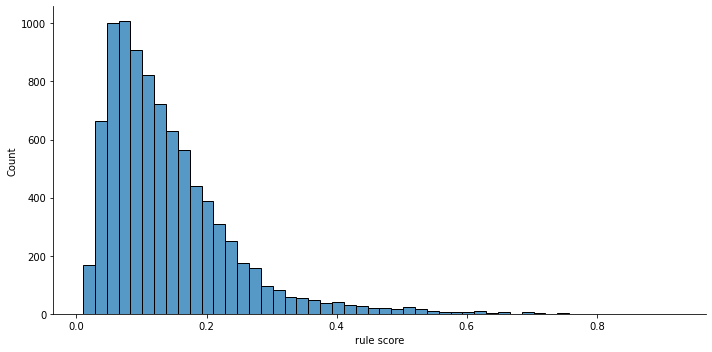

In [22]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame({ 'rule score': score })
sns.displot(df, x='rule score', bins=50, aspect=2)

In [15]:
rank = np.argsort(score)

In [16]:
score[rank[-1]]

0.9882245696894479

In [9]:
import bisect

1. one cluster or severa

In [86]:
mat.shape

(8837, 1040)

<AxesSubplot:xlabel='x', ylabel='y'>

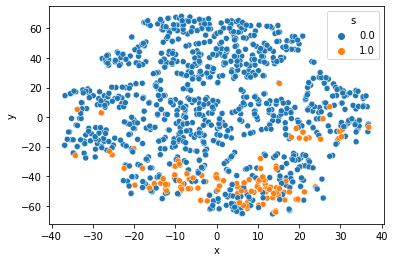

In [28]:
df = pd.DataFrame({ 'x': X[:, 0], 'y': X[:, 1], 's': mat[rank[-8]] })
sns.scatterplot(data=df, x='x', y='y', hue='s')

In [39]:
scores[4][rank[-4]]

0.5010269216979877

In [40]:
paths[rank[-4]]

{'range': {6: [-100000000000000.0, 0.9963249862194061],
  1: [12.285181522369385, 100000000000000.0],
  0: [-100000000000000.0, 3.9023869037628174],
  5: [1.0074078440666199, 100000000000000.0],
  22: [-100000000000000.0, 0.9158418476581573],
  17: [-100000000000000.0, 0.9944945871829987],
  39: [-100000000000000.0, 0.9944945871829987],
  41: [0.3400570750236511, 100000000000000.0]},
 'value': -0.212322183775471,
 'weight': 1,
 'tree_index': 42,
 'rule_index': 11,
 'name': 'r42_11',
 'confidence': 0.9607843137254902}

In [18]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE

X = TSNE(n_components=2).fit_transform(mat.transpose())


/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [7]:
df.corr()

,1,2,3,4,5,6
1,1.000000,0.967835,0.861987,0.894685,0.858835,0.890664
2,0.967835,1.000000,0.890943,0.924413,0.891946,0.925149
3,0.861987,0.890943,1.000000,0.970297,0.864701,0.891992
4,0.894685,0.924413,0.970297,1.000000,0.892176,0.922598
5,0.858835,0.891946,0.864701,0.892176,1.000000,0.966001
6,0.890664,0.925149,0.891992,0.922598,0.966001,1.000000


In [6]:
df = pd.DataFrame({
    '1': scores[0],
    '2': scores[1],
    '3': scores[2],
    '4': scores[3],
    '5': scores[4],
    '6': scores[5],
})

In [9]:
s = np.array(scores)

In [14]:
for i in range(6):
    print()

4709